In [1]:
# Script to extract geospatial data for all the halls in NTU to export as excel file, then solve using excel solver.
 
import pandas as pd 
import requests
import folium
import numpy as np
import geopandas
import pulp
from shapely.geometry import Point
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import time
import fiona
import math as math


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Initializing empty dataframe
df = pd.DataFrame()

# Creating hall column with all NTU halls inside 
df['Hall'] = ["NTU Hall 1","NTU Hall 2","NTU Hall 3","NTU Hall 4","NTU Hall 5","NTU Hall 6","NTU Hall 7","NTU Hall 8","NTU Hall 9","NTU Hall 10","NTU Hall 11","NTU Hall 12","NTU Hall 13","NTU Hall 14","NTU Hall 15","NTU Hall 16","NTU Crescent Hall","NTU Pioneer Hall","NTU Binjai Hall","NTU Tanjong Hall","NTU Banyan Hall","NTU Tamarind Hall","NTU Saraca Hall","NTU Graduate Hall 1","NTU Graduate Hall 2"]
# Retrieving a list of the halls 
halls = list(df['Hall'])

In [3]:
# This function returns me the specific latitude and longitude (in geospatial location) of all the halls within the list
def getcoordinates(location):
    req = requests.get(f'https://developers.onemap.sg/commonapi/search?searchVal={location}&returnGeom=Y&getAddrDetails=Y&pageNum=1')
    resultsdict = eval(req.text)
    if len(resultsdict['results']) > 0:
        return resultsdict['results'][0]['LATITUDE'], resultsdict['results'][0]['LONGITUDE']

# Initializing empty list for the coordinates 
coordinateslist = []

# Variables to count for failure etc 
count = 0 
failed_count = 0
for address in halls:
    try:
        if len(getcoordinates(address))>0:
            count = count + 1
            print('Extracting',count,'out of',len(halls),'addresses')
            coordinateslist.append(getcoordinates(address))
    except:
        count = count + 1           
        failed_count = failed_count + 1
        print('Failed to extract',count,'out of',len(halls),'addresses')
        coordinateslist.append(None)
print('Total Number of Addresses With No Coordinates',failed_count)


Extracting 1 out of 25 addresses
Extracting 2 out of 25 addresses
Extracting 3 out of 25 addresses
Extracting 4 out of 25 addresses
Extracting 5 out of 25 addresses
Extracting 6 out of 25 addresses
Extracting 7 out of 25 addresses
Extracting 8 out of 25 addresses
Extracting 9 out of 25 addresses
Extracting 10 out of 25 addresses
Extracting 11 out of 25 addresses
Extracting 12 out of 25 addresses
Extracting 13 out of 25 addresses
Extracting 14 out of 25 addresses
Extracting 15 out of 25 addresses
Extracting 16 out of 25 addresses
Extracting 17 out of 25 addresses
Extracting 18 out of 25 addresses
Extracting 19 out of 25 addresses
Extracting 20 out of 25 addresses
Extracting 21 out of 25 addresses
Extracting 22 out of 25 addresses
Extracting 23 out of 25 addresses
Extracting 24 out of 25 addresses
Extracting 25 out of 25 addresses
Total Number of Addresses With No Coordinates 0


In [5]:
# Coerce all coordinates into dataframe object 
df_coordinates = pd.DataFrame(coordinateslist)

# Combine the dataframes together by column
df_combined = pd.concat([df,df_coordinates], axis=1)

# Change the column names 
df_combined = df_combined.rename(columns={0: 'Latitude', 1: 'Longitude'})

# Set index as hall, leaving only latitude and longitude behind 
# df_combined = df_combined.set_index("Hall")

In [6]:
df_combined
# df_combined represents all the latitudes and longitudes.

,Hall,Latitude,Longitude
0,NTU Hall 1,1.34781409107287,103.686160006609
1,NTU Hall 2,1.34813378944082,103.685418467162
2,NTU Hall 3,1.35048608783448,103.681819176774
3,NTU Hall 4,1.34781154233311,103.684312141474
4,NTU Hall 5,1.34772330955894,103.684171039572
5,NTU Hall 6,1.34768803914928,103.687249152254
6,NTU Hall 7,1.34876060426178,103.684554273092
7,NTU Hall 8,1.34861138168565,103.684375324775
8,NTU Hall 9,1.34846450143933,103.684201083423
9,NTU Hall 10,1.34830669360141,103.68401470203


In [7]:
df_combined
# Inserting OBJECTID into gdf
df_combined.insert(loc=0, column='OBJECTID', value=np.arange(1,26,1))


In [8]:
df_combined

,OBJECTID,Hall,Latitude,Longitude
0,1,NTU Hall 1,1.34781409107287,103.686160006609
1,2,NTU Hall 2,1.34813378944082,103.685418467162
2,3,NTU Hall 3,1.35048608783448,103.681819176774
3,4,NTU Hall 4,1.34781154233311,103.684312141474
4,5,NTU Hall 5,1.34772330955894,103.684171039572
5,6,NTU Hall 6,1.34768803914928,103.687249152254
6,7,NTU Hall 7,1.34876060426178,103.684554273092
7,8,NTU Hall 8,1.34861138168565,103.684375324775
8,9,NTU Hall 9,1.34846450143933,103.684201083423
9,10,NTU Hall 10,1.34830669360141,103.68401470203


In [9]:
lat_points = []
long_points = []

for i in range (0,len(df_combined),1):
    for coordinate in df_combined['Latitude']:
        lat_points.append(float(coordinate))
    for coordinate in df_combined['Longitude']:
        long_points.append(float(coordinate))

polygon_geom = Polygon(zip(long_points, lat_points))
crs = 'epsg:4326'
polygon = geopandas.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])

polygon.to_file(filename='polygon.geojson', driver='GeoJSON')
polygon.to_file(filename='polygon.shp', driver="ESRI Shapefile")


<AxesSubplot: >

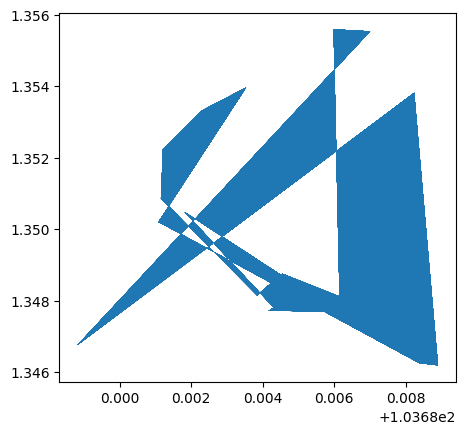

In [10]:
study_area = geopandas.read_file("polygon.shp").dissolve()
study_area.plot()


In [11]:
hallstest = df_combined[['Latitude', 'Longitude']]
halltestlist = hallstest.values.tolist()
len(halltestlist)
halltestlist[7]


m = folium.Map([1.3496, 103.6846], zoom_start=16, tiles='cartodbpositron')
for hall in range(0, len(halltestlist)):
    folium.Marker(halltestlist[hall],
                  popup=df_combined['Hall'][hall]).add_to(m)
m





From the above map, we can tell that there are some errors in OneMap API in extracting data. 

Quite a number of halls are wrong, so we will manually data clean unfortunately.

In [12]:
df_combined

,OBJECTID,Hall,Latitude,Longitude
0,1,NTU Hall 1,1.34781409107287,103.686160006609
1,2,NTU Hall 2,1.34813378944082,103.685418467162
2,3,NTU Hall 3,1.35048608783448,103.681819176774
3,4,NTU Hall 4,1.34781154233311,103.684312141474
4,5,NTU Hall 5,1.34772330955894,103.684171039572
5,6,NTU Hall 6,1.34768803914928,103.687249152254
6,7,NTU Hall 7,1.34876060426178,103.684554273092
7,8,NTU Hall 8,1.34861138168565,103.684375324775
8,9,NTU Hall 9,1.34846450143933,103.684201083423
9,10,NTU Hall 10,1.34830669360141,103.68401470203


In [13]:
# Hall 1
df_combined.at[0,'Latitude']=1.3458
df_combined.at[0,'Longitude']=103.6877

# Hall 2
df_combined.at[1, 'Latitude'] = 1.3478
df_combined.at[1, 'Longitude'] = 103.6862

# Hall 4
df_combined.at[3, 'Latitude'] = 1.3440
df_combined.at[3, 'Longitude'] = 103.6859

# Hall 5
df_combined.at[4, 'Latitude'] = 1.3444
df_combined.at[4, 'Longitude'] = 103.6872

# Hall 5
df_combined.at[4, 'Latitude'] = 1.3444
df_combined.at[4, 'Longitude'] = 103.6872

# Hall 7
df_combined.at[6, 'Latitude'] = 1.3547
df_combined.at[6, 'Longitude'] = 103.6841

# Hall 8
df_combined.at[7, 'Latitude'] = 1.3509
df_combined.at[7, 'Longitude'] = 103.6852

# Hall 9
df_combined.at[8, 'Latitude'] = 1.3526
df_combined.at[8, 'Longitude'] = 103.6854

# Hall 10
df_combined.at[9, 'Latitude'] = 1.3543
df_combined.at[9, 'Longitude'] = 103.6857

# Hall 11
df_combined.at[10, 'Latitude'] = 1.3547
df_combined.at[10, 'Longitude'] = 103.6863

# Binjai Hall
df_combined.at[18, 'Latitude'] = 1.3538
df_combined.at[18, 'Longitude'] = 103.6877

# Tanjong Hall
df_combined.at[19, 'Latitude'] = 1.3539
df_combined.at[19, 'Longitude'] = 103.6881

# Banyan Hall
df_combined.at[20, 'Latitude'] = 1.3542
df_combined.at[20, 'Longitude'] = 103.6885

# Tamarind Hall
df_combined.at[21, 'Latitude'] = 1.3547
df_combined.at[21, 'Longitude'] = 103.6849

# Saraca Hall
df_combined.at[22, 'Latitude'] = 1.3552
df_combined.at[22, 'Longitude'] = 103.6850


In [14]:
fixed_lat_points = []
fixed_long_points = []

for i in range(0, len(df_combined), 1):
    for coordinate in df_combined['Latitude']:
        lat_points.append(float(coordinate))
    for coordinate in df_combined['Longitude']:
        long_points.append(float(coordinate))

polygon_geom = Polygon(zip(long_points, lat_points))
crs = 'epsg:4326'
polygon = geopandas.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])

polygon.to_file(filename='polygon_fixed.geojson', driver='GeoJSON')
polygon.to_file(filename='polygon_fixed.shp', driver="ESRI Shapefile")


In [15]:
hallstest2 = df_combined[['Latitude', 'Longitude']]
halltestlist2 = hallstest2.values.tolist()
len(halltestlist2)
halltestlist2[7]


[1.3509, 103.6852]

In [16]:
m2 = folium.Map(location=[1.3496, 103.6846], zoom_start=16, tiles='cartodbpositron')
for hall in range(0, len(halltestlist2)):
    folium.Marker(halltestlist2[hall],
             popup=df_combined['Hall'][hall]).add_to(m2)
m2


Now that we have the correct mapping of all the halls in NTU, we want to extract the geometric area of the halls for a more thorough visualization.

In [17]:
geopandas.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
study_area = geopandas.read_file('Study Area.kml', driver='KML')


<AxesSubplot: >

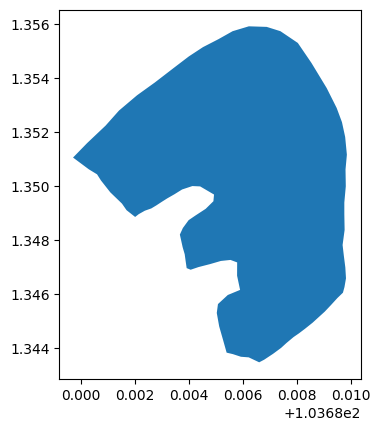

In [18]:
study_area.plot()

In [19]:
facility_points_gdf = geopandas.GeoDataFrame(
    df_combined, geometry=geopandas.points_from_xy(
        df_combined.Longitude, df_combined.Latitude))
facility_points_gdf


,OBJECTID,Hall,Latitude,Longitude,geometry
0,1,NTU Hall 1,1.3458,103.6877,POINT (103.68770 1.34580)
1,2,NTU Hall 2,1.3478,103.6862,POINT (103.68620 1.34780)
2,3,NTU Hall 3,1.35048608783448,103.681819176774,POINT (103.68182 1.35049)
3,4,NTU Hall 4,1.344,103.6859,POINT (103.68590 1.34400)
4,5,NTU Hall 5,1.3444,103.6872,POINT (103.68720 1.34440)
5,6,NTU Hall 6,1.34768803914928,103.687249152254,POINT (103.68725 1.34769)
6,7,NTU Hall 7,1.3547,103.6841,POINT (103.68410 1.35470)
7,8,NTU Hall 8,1.3509,103.6852,POINT (103.68520 1.35090)
8,9,NTU Hall 9,1.3526,103.6854,POINT (103.68540 1.35260)
9,10,NTU Hall 10,1.3543,103.6857,POINT (103.68570 1.35430)


In [20]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from matplotlib_scalebar.scalebar import ScaleBar

dv_colors = [
    "darkslategray",
    "lightskyblue",
    "limegreen",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "thistle",
    "lavender",
    "saddlebrown",
]


def plot_results(model, facility_points, title):
    def define_edgecolor(idf):
        if "predefined_loc" in idf.columns:
            if idf.predefined_loc.iloc[0]:
                return "red"

        return "k"

    def define_label(idf):
        if "predefined_loc" in idf.columns:
            if idf.predefined_loc.iloc[0]:
                return " (predefined)"

        return ""

    fac_sites = []

    for i in range(len(facility_points)):
        if model.fac_vars[i].varValue == 1:
            fac_sites.append(i)

    sited_facilities = range(len(fac_sites))

    fig, ax = plt.subplots(figsize=(10, 15))
    legend_elements = []

    facility_points.plot(ax=ax, color='brown', marker="*",
                         markersize=80, zorder=2)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='brown',
        marker="*",
        linewidth=0,
        label=f'facility sites ($n$={len(facility_points)})'
    ))

    study_area.plot(ax=ax, alpha=.5, fc="tan", ec="k", zorder=1)
    _patch = Patch(alpha=.5, fc="tan", ec="k", label="Dissolved Service Areas")
    legend_elements.append(_patch)

    for i in sited_facilities:
        facility_points.iloc[[fac_sites[i]]].plot(ax=ax,
                                                  marker="*",
                                                  markersize=200 * 3.0,
                                                  alpha=0.8,
                                                  zorder=4,
                                                  edgecolor=define_edgecolor(
                                                      facility_points.iloc[[fac_sites[i]]]),
                                                  facecolor=dv_colors[i])

    for i in sited_facilities:

        fac = fac_sites[i]
        fname = facility_points.iloc[[fac]]["NAME"]
        fname = f"{fname.squeeze().replace('_', ' ')}"

        legend_elements.append(mlines.Line2D(
            [],
            [],
            color=dv_colors[i],
            marker="*",
            ms=20 / 2,
            markeredgecolor=define_edgecolor(
                facility_points.iloc[[fac_sites[i]]]),
            linewidth=0,
            alpha=0.8,
            label=f"{fname}" +
            define_label(facility_points.iloc[[fac_sites[i]]]),
        ))

    plt.title(title, fontweight="bold")
    plt.legend(handles=legend_elements, loc='upper left',
               bbox_to_anchor=(1.05, 1))

    x, y, xyc, arrow_length, c = 0.925, 0.15, "axes fraction", 0.1, "center"
    xy, xyt = (x, y), (x, y-arrow_length)
    ap = dict(facecolor="black", width=5, headwidth=10)
    kws = dict(arrowprops=ap, ha=c, va=c, fontsize=20)
    plt.annotate("N", xy=xy, xycoords=xyc, xytext=xyt, **kws)

    plt.gca().add_artist(ScaleBar(1))


In [21]:
for _df in [facility_points_gdf, study_area]:
    _df.set_crs("EPSG:4326", inplace=True)
    _df.to_crs("EPSG:7131", inplace=True)


In [22]:
from spopt.locate import PDispersion


In [23]:
#number of facilities to be sited
p = 3

start_1 = time.time()
p_dispersion = PDispersion.from_geodataframe(
    facility_points_gdf, "geometry", p, distance_metric="euclidean")
end_1 = time.time()

time_spent_1 = end_1 - start_1


In [24]:
start_2 = time.time()
p_dispersion = p_dispersion.solve(pulp.PULP_CBC_CMD(msg=False, warmStart=True))
end_2 = time.time()

time_spent_2 = end_2 - start_2
total_time = time_spent_1 + time_spent_2


KeyError: 'NAME'

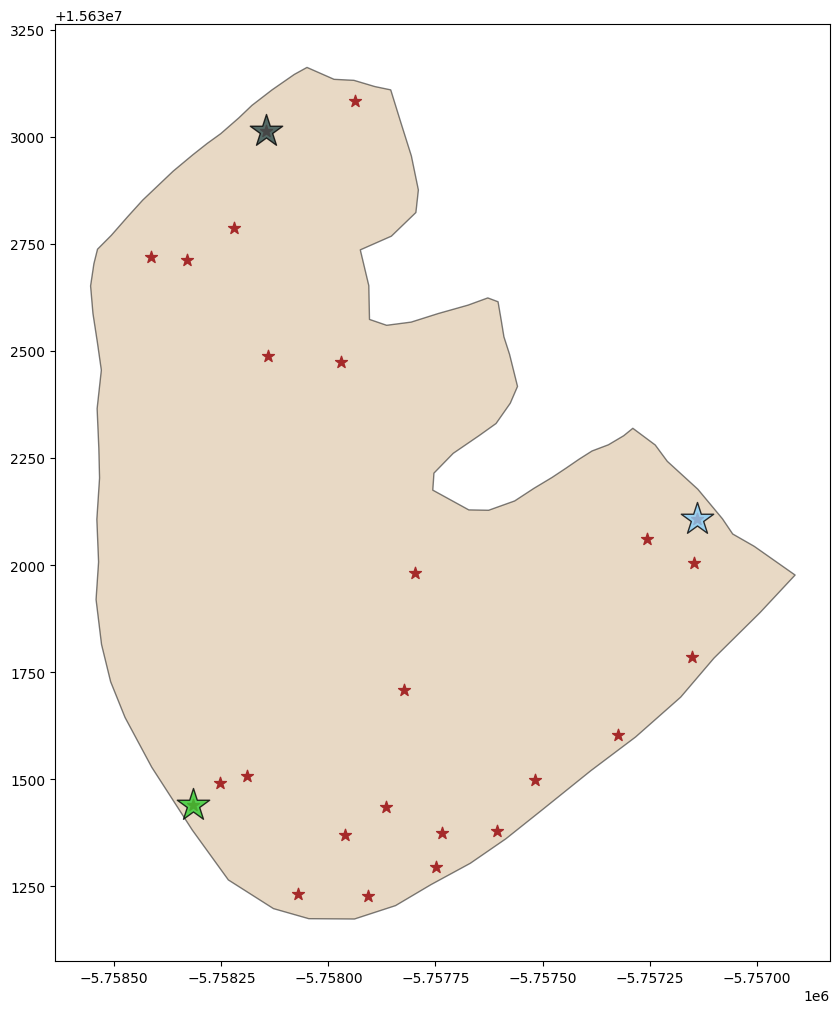

In [25]:
plot_results(p_dispersion, facility_points_gdf, "P-Dispersion")


From the above cell, we observe that the model has selected Banyan Hall, Hall 16 and Hall 5 as ideal facility locations.

This corresponds to the original location set planning 4 problem, which aims to maximise the minimum distance between facility locations in order to prevent cannibalization. 